In [257]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from matplotlib.pyplot import figure
import json
import datetime as dt
from collections import Counter
import glob
%matplotlib inline


import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest

import nltk
from nltk.corpus import stopwords
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor


# Loading the Datasets

In [258]:
files = [file for file in glob.glob('../project/data/*.{}'.format('csv'))]
sorted(files)

#countries = ['US', 'GB', 'DE', 'CA', 'FR', 'MX']
#USA, Great Britain, Germany, Canada, France, Mexico

['../project/data/CAvideos.csv',
 '../project/data/DEvideos.csv',
 '../project/data/FRvideos.csv',
 '../project/data/GBvideos.csv',
 '../project/data/MXvideos.csv',
 '../project/data/USvideos.csv']

In [259]:
df_raw = list()
for csv in files:
    df_mid = pd.read_csv(csv, encoding = "ISO-8859-1")
    df_mid['country'] = csv[16:18] #Adding "country" column
    df_raw.append(df_mid)

df = pd.concat(df_raw)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 242761 entries, 0 to 38915
Data columns (total 17 columns):
video_id                  242761 non-null object
trending_date             242761 non-null object
title                     242761 non-null object
channel_title             242761 non-null object
category_id               242761 non-null int64
publish_time              242761 non-null object
tags                      242761 non-null object
views                     242761 non-null int64
likes                     242761 non-null int64
dislikes                  242761 non-null int64
comment_count             242761 non-null int64
thumbnail_link            242761 non-null object
comments_disabled         242761 non-null bool
ratings_disabled          242761 non-null bool
video_error_or_removed    242761 non-null bool
description               231595 non-null object
country                   242761 non-null object
dtypes: bool(3), int64(5), object(9)
memory usage: 28.5+ MB


In [260]:
df.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,country
0,SbOwzAl9ZfQ,17.14.11,CapÃ­tulo 12 | MasterChef 2017,MasterChef 2017,24,2017-11-13T06:06:22.000Z,"MasterChef Junior 2017|""TV Azteca""|""recetas""|""...",310130,4182,361,1836,https://i.ytimg.com/vi/SbOwzAl9ZfQ/default.jpg,False,False,False,Disfruta la presencia del Chef Torreblanca en ...,MX
1,klOV6Xh-DnI,17.14.11,ALEXA EX-INTEGRANTE DEL GRUPO TIMBIRICHE RENUN...,Micky Contreras Martinez,22,2017-11-13T05:11:58.000Z,La Voz Mexico 7,104972,271,174,369,https://i.ytimg.com/vi/klOV6Xh-DnI/default.jpg,False,False,False,ALEXA EX-INTEGRANTE DEL GRUPO TIMBIRICHE RENUN...,MX
2,6L2ZF7Qzsbk,17.14.11,LOUIS CKAGÃ - EL PULSO DE LA REPÃBLICA,El Pulso De La RepÃºblica,25,2017-11-13T17:00:02.000Z,"Chumel Torres|""El Pulso de la Republica""|""noti...",136064,10105,266,607,https://i.ytimg.com/vi/6L2ZF7Qzsbk/default.jpg,False,False,False,La canciÃ³n del principio se llama âEste esp...,MX
3,hcY52MFWMDM,17.14.11,Sismo de 6.7 sacude Costa Rica 12 Noviembre 2017,Casanare,25,2017-11-13T03:47:10.000Z,"temblor|""costa rica""|""sismo en costa rica""",96153,378,171,208,https://i.ytimg.com/vi/hcY52MFWMDM/default.jpg,False,False,False,El video es de un Walmart en el pais centroame...,MX
4,_OXDcGPVAa4,17.14.11,DOG HACKS | MUSAS LESSLIE LOS POLINESIOS,Musas,26,2017-11-13T19:17:48.000Z,"MUSAS|""lesslie""|""karen""|""hacks""|""perros""|""dogs...",499965,57781,681,7428,https://i.ytimg.com/vi/_OXDcGPVAa4/default.jpg,False,False,False,MI HERMANO NARRA MI RUTINA DE MAQUILLAJE\nhttp...,MX


# Preprocessing the Datasets

In [261]:
df.apply(lambda x: sum(x.isnull()))

video_id                      0
trending_date                 0
title                         0
channel_title                 0
category_id                   0
publish_time                  0
tags                          0
views                         0
likes                         0
dislikes                      0
comment_count                 0
thumbnail_link                0
comments_disabled             0
ratings_disabled              0
video_error_or_removed        0
description               11166
country                       0
dtype: int64

#### Since there is no NaN in cloumns other than "description", and I don't want to lose too much infomation by dropping a lot of rows (19478) becuase of NaN in "description", therefore, I keep all the data. 

In [262]:
df['trending_date'] = pd.to_datetime(df['trending_date'], format='%y.%d.%m')
df['trending_date'].head()

0   2017-11-14
1   2017-11-14
2   2017-11-14
3   2017-11-14
4   2017-11-14
Name: trending_date, dtype: datetime64[ns]

In [263]:
df['publish_time'] = pd.to_datetime(df['publish_time'], format='%Y-%m-%dT%H:%M:%S.%fZ')
df['publish_time'].head()

0   2017-11-13 06:06:22
1   2017-11-13 05:11:58
2   2017-11-13 17:00:02
3   2017-11-13 03:47:10
4   2017-11-13 19:17:48
Name: publish_time, dtype: datetime64[ns]

In [264]:
df["trending_Year"]=df["trending_date"].apply(lambda time:time.year).astype(int)
df["trending_Month"]=df["trending_date"].apply(lambda time:time.month).astype(int)
df["trending_Day"]=df["trending_date"].apply(lambda time:time.day).astype(int)
df["trending_Day_of_Week"]=df["trending_date"].apply(lambda time:time.dayofweek).astype(int)
df["publish_Year"]=df["publish_time"].apply(lambda time:time.year).astype(int)
df["publish_Month"]=df["publish_time"].apply(lambda time:time.month).astype(int)
df["publish_Day"]=df["publish_time"].apply(lambda time:time.day).astype(int)
df["publish_Day_of_Week"]=df["publish_time"].apply(lambda time:time.dayofweek).astype(int)
df["publish_Hour"]=df["publish_time"].apply(lambda time:time.hour).astype(int)

# map the 0-6 to correct day of week
dayofweek = {0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'}
df["publish_Day_of_Week"]=df["publish_Day_of_Week"].map(dayofweek)
df["trending_Day_of_Week"]=df["trending_Day_of_Week"].map(dayofweek)

In [265]:
# separates 'publish_time' column into 'publish_date' and 'publish_time'
df.insert(4, 'publish_Date', df['publish_time'].dt.date)
df['publish_Time'] = df['publish_time'].dt.time
df[['publish_Date', 'publish_Time']].head()

,publish_Date,publish_Time
0,2017-11-13,06:06:22
1,2017-11-13,05:11:58
2,2017-11-13,17:00:02
3,2017-11-13,03:47:10
4,2017-11-13,19:17:48


In [266]:
#Add a new column represent the number of days that a video took from publishing to become trending
df['trending_date'] = pd.to_datetime(df['trending_date']).dt.date
df['publish_Date'] = pd.to_datetime(df['publish_Date']).dt.date

df['days_to_trending'] = (df.trending_date - df.publish_Date).dt.days
#df['days_to_trending'] = df["trending_date"] - df["publish_date"]

#df.head()

In [267]:
df['days_to_trending'].groupby(df['country']).describe()

,count,mean,std,min,25%,50%,75%,max
country,,,,,,,,
CA,40881.0,3.481495,59.735969,0.0,1.0,1.0,2.0,3658.0
DE,40840.0,1.850318,19.621608,0.0,1.0,1.0,2.0,2046.0
FR,40724.0,2.800953,45.952652,0.0,1.0,1.0,2.0,3190.0
GB,38916.0,36.762925,241.465979,0.0,5.0,10.0,18.0,3990.0
MX,40451.0,1.921559,41.644296,0.0,1.0,1.0,1.0,2975.0
US,40949.0,16.810423,146.014303,0.0,3.0,5.0,9.0,4215.0


#### Convert "trending_date" and "publish_time" to appropriate format. 

#### Get detail information about the timing will be very helpful for us to do the analysis of the relationship between the video popularity and some time factors. 

In [268]:
countries = ['CA', 'DE', 'FR', 'GB', 'US', 'MX']

cat_dic = {}
for country in countries:
    with open('../project/data/' + country + '_category_id.json', 'r') as file:
        json_obj = json.load(file)
    for item in json_obj['items']:
        cat_dic[int(item['id'])] = item['snippet']['title']


In [269]:
cat_dic

{1: 'Film & Animation',
 2: 'Autos & Vehicles',
 10: 'Music',
 15: 'Pets & Animals',
 17: 'Sports',
 18: 'Short Movies',
 19: 'Travel & Events',
 20: 'Gaming',
 21: 'Videoblogging',
 22: 'People & Blogs',
 23: 'Comedy',
 24: 'Entertainment',
 25: 'News & Politics',
 26: 'Howto & Style',
 27: 'Education',
 28: 'Science & Technology',
 30: 'Movies',
 31: 'Anime/Animation',
 32: 'Action/Adventure',
 33: 'Classics',
 34: 'Comedy',
 35: 'Documentary',
 36: 'Drama',
 37: 'Family',
 38: 'Foreign',
 39: 'Horror',
 40: 'Sci-Fi/Fantasy',
 41: 'Thriller',
 42: 'Shorts',
 43: 'Shows',
 44: 'Trailers',
 29: 'Nonprofits & Activism'}

In [270]:
df.insert(4, 'category', df['category_id'].map(cat_dic))
print(df[['category_id', 'category']].head())

   category_id         category
0           24    Entertainment
1           22   People & Blogs
2           25  News & Politics
3           25  News & Politics
4           26    Howto & Style


In [271]:
df = df.drop(['thumbnail_link'], axis = 1)
df.head()

,video_id,trending_date,title,channel_title,category,publish_Date,category_id,publish_time,tags,views,...,trending_Month,trending_Day,trending_Day_of_Week,publish_Year,publish_Month,publish_Day,publish_Day_of_Week,publish_Hour,publish_Time,days_to_trending
0,SbOwzAl9ZfQ,2017-11-14,CapÃ­tulo 12 | MasterChef 2017,MasterChef 2017,Entertainment,2017-11-13,24,2017-11-13 06:06:22,"MasterChef Junior 2017|""TV Azteca""|""recetas""|""...",310130,...,11,14,Tue,2017,11,13,Mon,6,06:06:22,1
1,klOV6Xh-DnI,2017-11-14,ALEXA EX-INTEGRANTE DEL GRUPO TIMBIRICHE RENUN...,Micky Contreras Martinez,People & Blogs,2017-11-13,22,2017-11-13 05:11:58,La Voz Mexico 7,104972,...,11,14,Tue,2017,11,13,Mon,5,05:11:58,1
2,6L2ZF7Qzsbk,2017-11-14,LOUIS CKAGÃ - EL PULSO DE LA REPÃBLICA,El Pulso De La RepÃºblica,News & Politics,2017-11-13,25,2017-11-13 17:00:02,"Chumel Torres|""El Pulso de la Republica""|""noti...",136064,...,11,14,Tue,2017,11,13,Mon,17,17:00:02,1
3,hcY52MFWMDM,2017-11-14,Sismo de 6.7 sacude Costa Rica 12 Noviembre 2017,Casanare,News & Politics,2017-11-13,25,2017-11-13 03:47:10,"temblor|""costa rica""|""sismo en costa rica""",96153,...,11,14,Tue,2017,11,13,Mon,3,03:47:10,1
4,_OXDcGPVAa4,2017-11-14,DOG HACKS | MUSAS LESSLIE LOS POLINESIOS,Musas,Howto & Style,2017-11-13,26,2017-11-13 19:17:48,"MUSAS|""lesslie""|""karen""|""hacks""|""perros""|""dogs...",499965,...,11,14,Tue,2017,11,13,Mon,19,19:17:48,1


#### Transform column "categroy_id" to corresponding categroy and replace it as new column named "category"
#### Each YouTube video also includes a thumbnail that is shown with their video. I will not be exploring thumbnail, therefore, I will remove this column. 

In [272]:
df = pd.get_dummies(df, columns = ['comments_disabled','ratings_disabled','video_error_or_removed'])

#df.info()

In [273]:
str_type = ['category']
for i in str_type:
    df[i] = df[i].astype(str)
    
int_type = ['views', 'likes', 'dislikes', 'comment_count']
for i in int_type:
    df[i] = df[i].astype(int)

df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 242761 entries, 0 to 38915
Data columns (total 32 columns):
video_id                        242761 non-null object
trending_date                   242761 non-null object
title                           242761 non-null object
channel_title                   242761 non-null object
category                        242761 non-null object
publish_Date                    242761 non-null object
category_id                     242761 non-null int64
publish_time                    242761 non-null datetime64[ns]
tags                            242761 non-null object
views                           242761 non-null int64
likes                           242761 non-null int64
dislikes                        242761 non-null int64
comment_count                   242761 non-null int64
description                     231595 non-null object
country                         242761 non-null object
trending_Year                   242761 non-null int64
trending

#### Change the data to appropriate types. 

In [274]:
#Nnumber of tags
tags=[x.count("|")+1 for x in df["tags"]]
df["Tags_count"]=tags
df["Tags_count"]

0        20
1         1
2        19
3         3
4        18
5         1
6         9
7        13
8        23
9         5
10       14
11       34
12       20
13       11
14       11
15        7
16       25
17        8
18        6
19        1
20        4
21       34
22       10
23        9
24        8
25        1
26       14
27       17
28       15
29        4
         ..
38886    15
38887    36
38888     1
38889    26
38890    22
38891     8
38892    21
38893     6
38894    33
38895    40
38896    24
38897    35
38898    30
38899    27
38900    10
38901    13
38902    21
38903     6
38904     7
38905     5
38906    13
38907    16
38908    23
38909    23
38910    10
38911     4
38912    41
38913    17
38914     8
38915    18
Name: Tags_count, Length: 242761, dtype: int64

In [275]:
def clean_tags(tag):
    if tag == '[none]': 
        return []
    return tag.lower().replace('"','').split('|')
df['tags'] = df['tags'].apply(clean_tags)
df.head()

,video_id,trending_date,title,channel_title,category,publish_Date,category_id,publish_time,tags,views,...,publish_Hour,publish_Time,days_to_trending,comments_disabled_False,comments_disabled_True,ratings_disabled_False,ratings_disabled_True,video_error_or_removed_False,video_error_or_removed_True,Tags_count
0,SbOwzAl9ZfQ,2017-11-14,CapÃ­tulo 12 | MasterChef 2017,MasterChef 2017,Entertainment,2017-11-13,24,2017-11-13 06:06:22,"[masterchef junior 2017, tv azteca, recetas, c...",310130,...,6,06:06:22,1,1,0,1,0,1,0,20
1,klOV6Xh-DnI,2017-11-14,ALEXA EX-INTEGRANTE DEL GRUPO TIMBIRICHE RENUN...,Micky Contreras Martinez,People & Blogs,2017-11-13,22,2017-11-13 05:11:58,[la voz mexico 7],104972,...,5,05:11:58,1,1,0,1,0,1,0,1
2,6L2ZF7Qzsbk,2017-11-14,LOUIS CKAGÃ - EL PULSO DE LA REPÃBLICA,El Pulso De La RepÃºblica,News & Politics,2017-11-13,25,2017-11-13 17:00:02,"[chumel torres, el pulso de la republica, noti...",136064,...,17,17:00:02,1,1,0,1,0,1,0,19
3,hcY52MFWMDM,2017-11-14,Sismo de 6.7 sacude Costa Rica 12 Noviembre 2017,Casanare,News & Politics,2017-11-13,25,2017-11-13 03:47:10,"[temblor, costa rica, sismo en costa rica]",96153,...,3,03:47:10,1,1,0,1,0,1,0,3
4,_OXDcGPVAa4,2017-11-14,DOG HACKS | MUSAS LESSLIE LOS POLINESIOS,Musas,Howto & Style,2017-11-13,26,2017-11-13 19:17:48,"[musas, lesslie, karen, hacks, perros, dogs, t...",499965,...,19,19:17:48,1,1,0,1,0,1,0,18


#### Clean up the 'tags' column by separating tags into a list. 

# Analysis

## 1. Trending time

### Use the hour information from the dataframe, and then count the number of publishing videos at each time clock and country. Then plot the fluctuation figure.

In [276]:
#dic = df.groupby('publish_Hour').count()['country']
dic1 = df[df['country'] == 'CA'].groupby("publish_Hour").count()["country"]
dic2 = df[df['country'] == 'US'].groupby("publish_Hour").count()["country"]
dic3 = df[df['country'] == 'MX'].groupby("publish_Hour").count()["country"]
dic4 = df[df['country'] == 'FR'].groupby("publish_Hour").count()["country"]
dic5 = df[df['country'] == 'DE'].groupby("publish_Hour").count()["country"]
dic6 = df[df['country'] == 'GB'].groupby("publish_Hour").count()["country"]

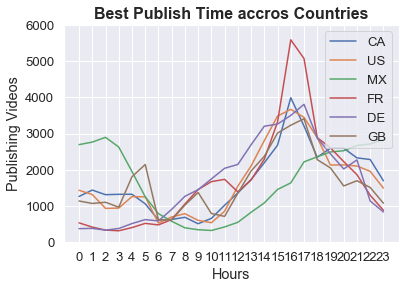

In [277]:
plt.plot(dic1, label = 'CA')
plt.plot(dic2, label = 'US')
plt.plot(dic3, label = 'MX')
plt.plot(dic4, label = 'FR')
plt.plot(dic5, label = 'DE')
plt.plot(dic6, label = 'GB')
plt.legend(loc='upper right')

plt.title("Best Publish Time accros Countries", fontsize=16, fontweight='bold')
plt.xlabel("Hours")
plt.ylabel("Publishing Videos")
plt.xticks(np.arange(0, 24, 1))
plt.yticks(np.arange(0, 7000, 1000))
plt.show()


#### It is easily to find out that the publishing time of trending videos concentrate at 4pm - 5pm for a day, (if want your videos have a greater possibility to be trending videos, upload them between 4pm and 5pm!) for almost all the countries we analysis. (This finding is not very applicable to MX, let's forget it for a while), next, it might be interesting to guess the reasons to this result. I will try to see if there are any relationships between the video category and the publishing amount. 
#### I will use heatmap to analysis this relationship. 

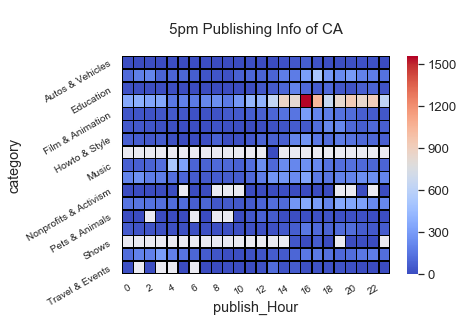

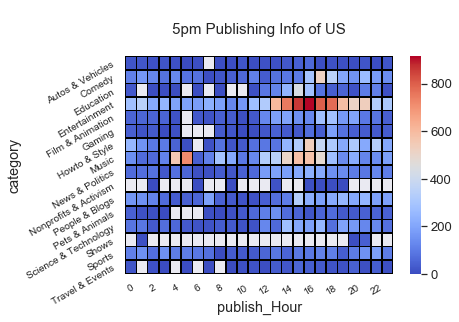

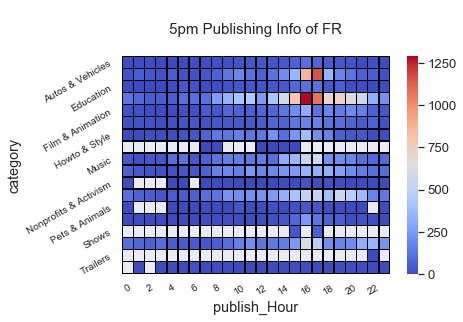

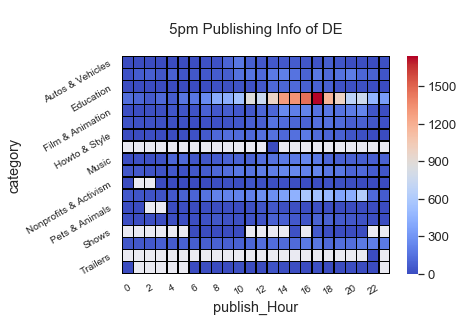

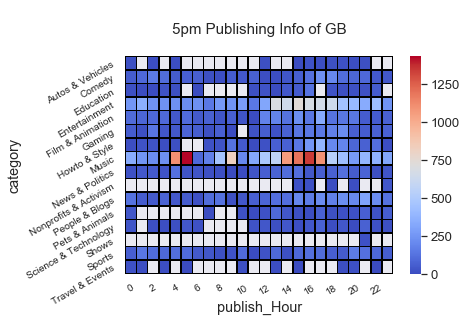

In [278]:
sprik_time1=df[df['country'] == 'CA'].groupby(["category", 'publish_Hour']).count()["video_id"].unstack()
ax1 = sns.heatmap(sprik_time1, cmap=cm.coolwarm, linewidths=0.5, linecolor='black')
plt.yticks(rotation=30, fontsize=10) 
plt.xticks(rotation=30, fontsize=10) 
plt.title("\n 5pm Publishing Info of CA \n ", fontsize=15)
plt.plot()
plt.show()

sprik_time2=df[df['country'] == 'US'].groupby(["category", 'publish_Hour']).count()["video_id"].unstack()
ax2 = sns.heatmap(sprik_time2, cmap=cm.coolwarm, linewidths=0.5, linecolor='black')
plt.yticks(rotation=30, fontsize=10) 
plt.xticks(rotation=30, fontsize=10) 
plt.title("\n 5pm Publishing Info of US \n ", fontsize=15)
plt.plot()
plt.show()

sprik_time3=df[df['country'] == 'FR'].groupby(["category", 'publish_Hour']).count()["video_id"].unstack()
ax3 = sns.heatmap(sprik_time3, cmap=cm.coolwarm, linewidths=0.5, linecolor='black')
plt.yticks(rotation=30, fontsize=10) 
plt.xticks(rotation=30, fontsize=10) 
plt.title("\n 5pm Publishing Info of FR \n ", fontsize=15)
plt.plot()
plt.show()

sprik_time4=df[df['country'] == 'DE'].groupby(["category", 'publish_Hour']).count()["video_id"].unstack()
ax4 = sns.heatmap(sprik_time4, cmap=cm.coolwarm, linewidths=0.5, linecolor='black')
plt.yticks(rotation=30, fontsize=10) 
plt.xticks(rotation=30, fontsize=10) 
plt.title("\n 5pm Publishing Info of DE \n ", fontsize=15)
plt.plot()
plt.show()

sprik_time5=df[df['country'] == 'GB'].groupby(["category", 'publish_Hour']).count()["video_id"].unstack()
ax5 = sns.heatmap(sprik_time5, cmap=cm.coolwarm, linewidths=0.5, linecolor='black')
plt.yticks(rotation=30, fontsize=10) 
plt.xticks(rotation=30, fontsize=10) 
plt.title("\n 5pm Publishing Info of GB \n ", fontsize=15)
plt.plot()
plt.show()

#### From the graphs above, we can conclude that at the best time of uploading a video to Youtube, the best category to upload is different for different countries. 

#### In CA, US, and FR, it is best if youtubers can upload Entertainment videos at 4pm.
#### In DE, it is best if youtubers can upload Entertainment videos at 5pm.
#### However, in GE, it is best if youtubers can upload Music videos at 5am, upload Music videos at 4pm is good choice as well. 

#### It might be interesting to figure out why it is best to upload Music video in GE instead of Entertainment videos like other countires. 


In [279]:
df.groupby(df['country'])['days_to_trending'].mean().to_frame()

,days_to_trending
country,
CA,3.481495
DE,1.850318
FR,2.800953
GB,36.762925
MX,1.921559
US,16.810423


In [280]:
df.groupby(df['country']).sum()

,category_id,views,likes,dislikes,comment_count,trending_Year,trending_Month,trending_Day,publish_Year,publish_Month,publish_Day,publish_Hour,days_to_trending,comments_disabled_False,comments_disabled_True,ratings_disabled_False,ratings_disabled_True,video_error_or_removed_False,video_error_or_removed_True,Tags_count
country,,,,,,,,,,,,,,,,,,,,
CA,850143,46891975069,1618179878,82137919,206161849,82488266,213977,648113,82487753,215573,644368,564594,142327,40298.0,583.0,40602.0,279.0,40854.0,27.0,800372
DE,845626,24645115205,893395538,57059031,113774380,82405522,213715,647456,82405165,215578,645451,586542,75567,39796.0,1044.0,40168.0,672.0,40826.0,14.0,733959
FR,819522,17100897444,708144090,33188528,74624804,82171437,213240,645783,82171016,214642,642695,601648,114066,39835.0,889.0,40020.0,704.0,40702.0,22.0,598762
GB,654876,230069198174,5234962944,296250384,509346351,78522895,204103,618660,78518577,209642,592552,503421,1430666,38233.0,683.0,38644.0,272.0,38847.0,69.0,700439
MX,849598,13849692994,641627186,30223385,82506287,81620523,211664,640756,81620209,212849,641673,493509,77729,40011.0,440.0,39817.0,634.0,40427.0,24.0,587111
US,817851,96671770152,3041147198,151978155,345888164,82625482,214282,649347,82623398,216515,652804,563732,688370,40316.0,633.0,40780.0,169.0,40926.0,23.0,808183


#### In average, it takes much more time for videos uploaded in GB and US to become trending! 
#### The reason might be the total amount of views ( likes and dislikes) in these two countries are much higher than other countries. 

### Next, let's see if there is relationship between weekdays and months of uploading and trending videos. 

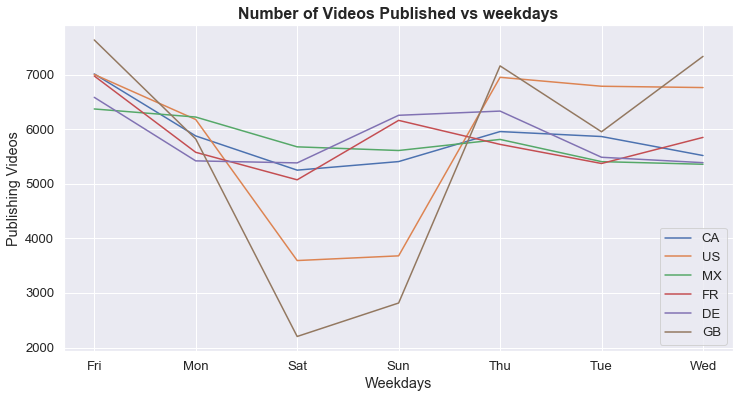

In [281]:
count1 = df[df['country'] == 'CA'].groupby("publish_Day_of_Week").count()["country"]
count2 = df[df['country'] == 'US'].groupby("publish_Day_of_Week").count()["country"]
count3 = df[df['country'] == 'MX'].groupby("publish_Day_of_Week").count()["country"]
count4 = df[df['country'] == 'FR'].groupby("publish_Day_of_Week").count()["country"]
count5 = df[df['country'] == 'DE'].groupby("publish_Day_of_Week").count()["country"]
count6 = df[df['country'] == 'GB'].groupby("publish_Day_of_Week").count()["country"]

plt.figure(figsize=(12,6))
plt.plot(count1, label = 'CA')
plt.plot(count2, label = 'US')
plt.plot(count3, label = 'MX')
plt.plot(count4, label = 'FR')
plt.plot(count5, label = 'DE')
plt.plot(count6, label = 'GB')
plt.legend(loc='lower right')

plt.title("Number of Videos Published vs weekdays", fontsize=16, fontweight='bold')
plt.xlabel("Weekdays")
plt.ylabel("Publishing Videos")
plt.show()

#### From the figure above, we can conclude that videos published on Friday have a higher chance to become trending, and Saturday's videos are not highly likely to become trending. This pattern works for all six countries we analysis here. 

## 2. Natural Language Processing
### Developed a function to clean the data better understand the occurance of certain keywords being used in the titles.
#### By converting to lowercase, removing extra white spaces, removing numerical values and punctuations, tokenizing into words, removing non-alphabetical words and ‘Stop words’, and lemmatizing words. 

In [282]:
df_us = df[df['country'] == 'US']
df_us.head()

,video_id,trending_date,title,channel_title,category,publish_Date,category_id,publish_time,tags,views,...,publish_Hour,publish_Time,days_to_trending,comments_disabled_False,comments_disabled_True,ratings_disabled_False,ratings_disabled_True,video_error_or_removed_False,video_error_or_removed_True,Tags_count
0,2kyS6SvSYSE,2017-11-14,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,People & Blogs,2017-11-13,22,2017-11-13 17:13:01,[shantell martin],748374,...,17,17:13:01,1,1,0,1,0,1,0,1
1,1ZAPwfrtAFY,2017-11-14,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,Entertainment,2017-11-13,24,2017-11-13 07:30:00,"[last week tonight trump presidency, last week...",2418783,...,7,07:30:00,1,1,0,1,0,1,0,4
2,5qpjK5DgCt4,2017-11-14,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,Comedy,2017-11-12,23,2017-11-12 19:05:24,"[racist superman, rudy, mancuso, king, bach, r...",3191434,...,19,19:05:24,2,1,0,1,0,1,0,23
3,puqaWrEC7tY,2017-11-14,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,Entertainment,2017-11-13,24,2017-11-13 11:00:04,"[rhett and link, gmm, good mythical morning, r...",343168,...,11,11:00:04,1,1,0,1,0,1,0,27
4,d380meD0W0M,2017-11-14,I Dare You: GOING BALD!?,nigahiga,Entertainment,2017-11-12,24,2017-11-12 18:01:41,"[ryan, higa, higatv, nigahiga, i dare you, idy...",2095731,...,18,18:01:41,2,1,0,1,0,1,0,14


In [283]:
def clean_titles(title):
    #print(type(title))
    tokens = title.lower().split()
    cleaned = []
    sw = set(stopwords.words('english'))
    for token in tokens:
        if token.startswith('$') or token.isnumeric() or not token.isalnum() or token in sw:  # Remove money amount, non-alphanumeric tokens, or stopwords
            continue
        else:
            cleaned.append(token)
    return ' '.join(cleaned)

def clean_tags(tags):
    tokens = str(tags).lower().split()
    cleaned = []
    sw = set(stopwords.words('english'))
    for token in tokens:
        if token.startswith('$') or token.isnumeric() or not token.isalnum() or token in sw:  # Remove money amount, non-alphanumeric tokens, or stopwords
            continue
        else:
            cleaned.append(token)
    return ' '.join(cleaned)
    

df_us['title_cl'] = df_us['title'].apply(clean_titles)
df_us['tags_cl'] = df_us['tags'].apply(clean_tags)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [284]:
df_us.head()

,video_id,trending_date,title,channel_title,category,publish_Date,category_id,publish_time,tags,views,...,days_to_trending,comments_disabled_False,comments_disabled_True,ratings_disabled_False,ratings_disabled_True,video_error_or_removed_False,video_error_or_removed_True,Tags_count,title_cl,tags_cl
0,2kyS6SvSYSE,2017-11-14,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,People & Blogs,2017-11-13,22,2017-11-13 17:13:01,[shantell martin],748374,...,1,1,0,1,0,1,0,1,want talk marriage,
1,1ZAPwfrtAFY,2017-11-14,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,Entertainment,2017-11-13,24,2017-11-13 07:30:00,"[last week tonight trump presidency, last week...",2418783,...,1,1,0,1,0,1,0,4,trump last week tonight john oliver,week tonight trump week tonight donald oliver
2,5qpjK5DgCt4,2017-11-14,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,Comedy,2017-11-12,23,2017-11-12 19:05:24,"[racist superman, rudy, mancuso, king, bach, r...",3191434,...,2,1,0,1,0,1,0,23,racist superman rudy king bach lele pons,mancuso poo bear black white official music x ...
3,puqaWrEC7tY,2017-11-14,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,Entertainment,2017-11-13,24,2017-11-13 11:00:04,"[rhett and link, gmm, good mythical morning, r...",343168,...,1,1,0,1,0,1,0,27,nickelback real,mythical link good mythical mythical morning r...
4,d380meD0W0M,2017-11-14,I Dare You: GOING BALD!?,nigahiga,Entertainment,2017-11-12,24,2017-11-12 18:01:41,"[ryan, higa, higatv, nigahiga, i dare you, idy...",2095731,...,2,1,0,1,0,1,0,14,dare going,dare


#### I will look at what words are commonly used in video titles, as I think that word choice will be an important factor for Trending videos.

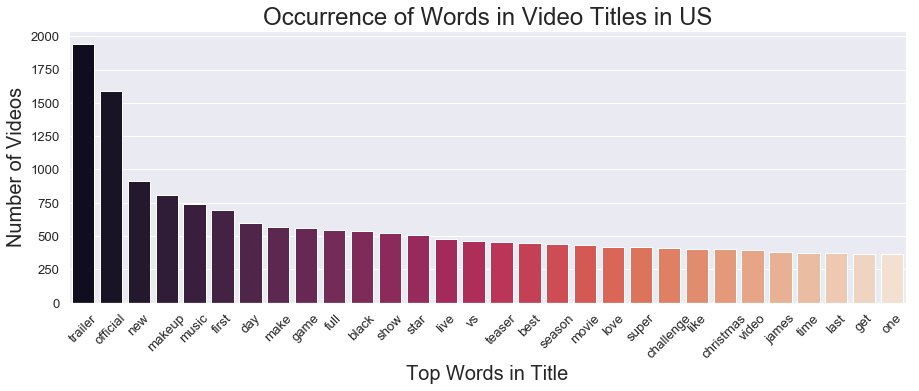

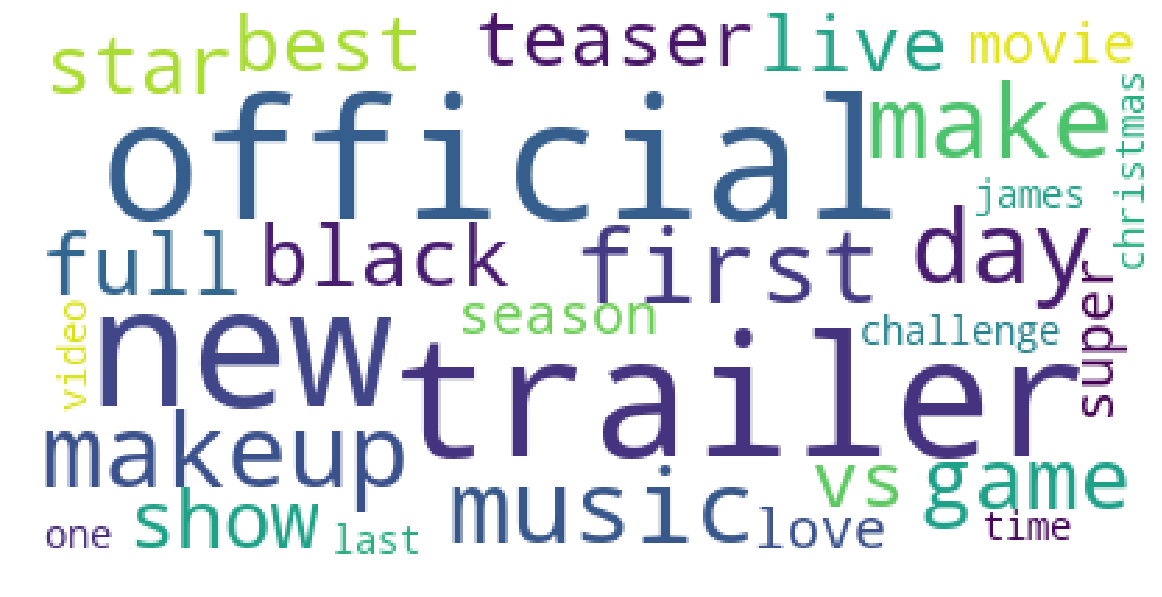

In [330]:
# from collections, a Counter object
cnt = Counter()

# Finding the occurence of words in video titles
for i in df_us['title_cl']:
    for token in i.split():
        cnt[token] += 1

# Finding the 50 most used words in video titles
dist = cnt.most_common(30)
top_words = []
freqs = []
for word, freq in dist:
    top_words.append(word)
    freqs.append(freq)
    
# Graphing occurrence of words in title
fig= plt.figure(figsize=(15,5))
plt.xticks(rotation=45)
sns.barplot(top_words, freqs, palette="rocket")
sns.set_style("whitegrid")
sns.set(font_scale=1.2)
plt.xlabel('Top Words in Title', fontsize=20)
plt.ylabel('Number of Videos', fontsize=20)
plt.title('Occurrence of Words in Video Titles in US', fontsize=24)
plt.show()

# Graphing the wordcloud for title 
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize
from wordcloud import WordCloud, STOPWORDS

def wc(data,bgcolor,title):
    plt.figure(figsize = (20,20))
    wc = WordCloud(background_color = bgcolor, max_words = 100,  max_font_size = 60)
    wc.generate(' '.join(data))
    plt.imshow(wc)
    plt.axis('off')
wc(top_words,'white','Common Words' )

#### From Figures above, we can see that the top three words are trailer, official, and new, with "trailer" and "official" having a great number of more occurences than all other words. I think this might because viewers are very interested in "official trailer" and general have curiosity of "new" things. 

#### I will do the same analysis for video tags, since I think adding tags is a good approach to attract viewers and might be helpful if we can get some insights on this. 

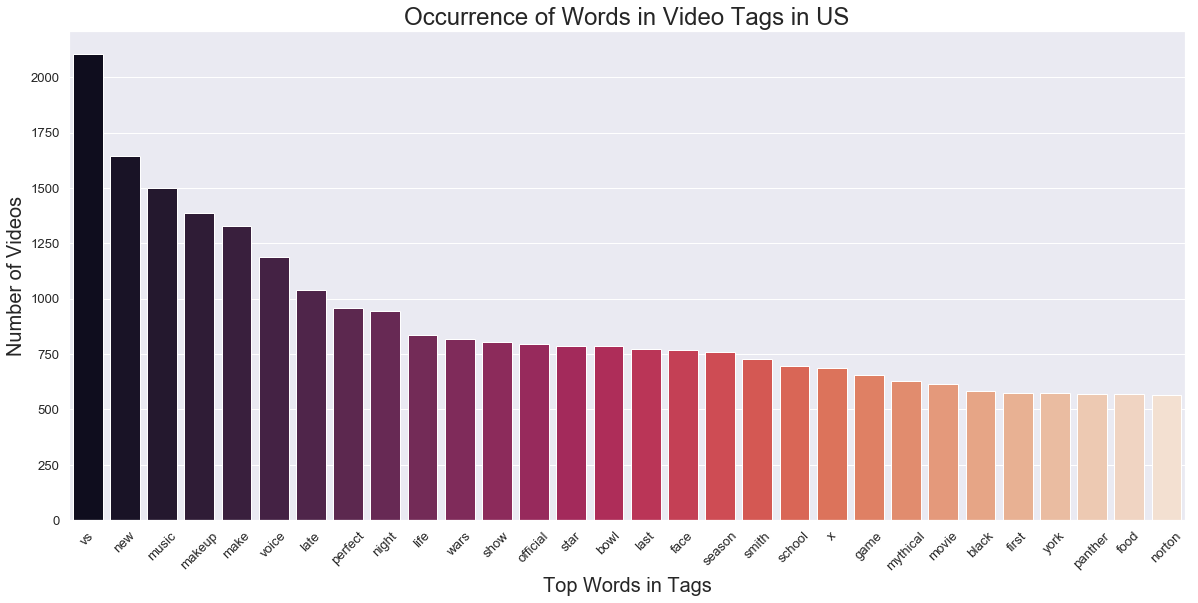

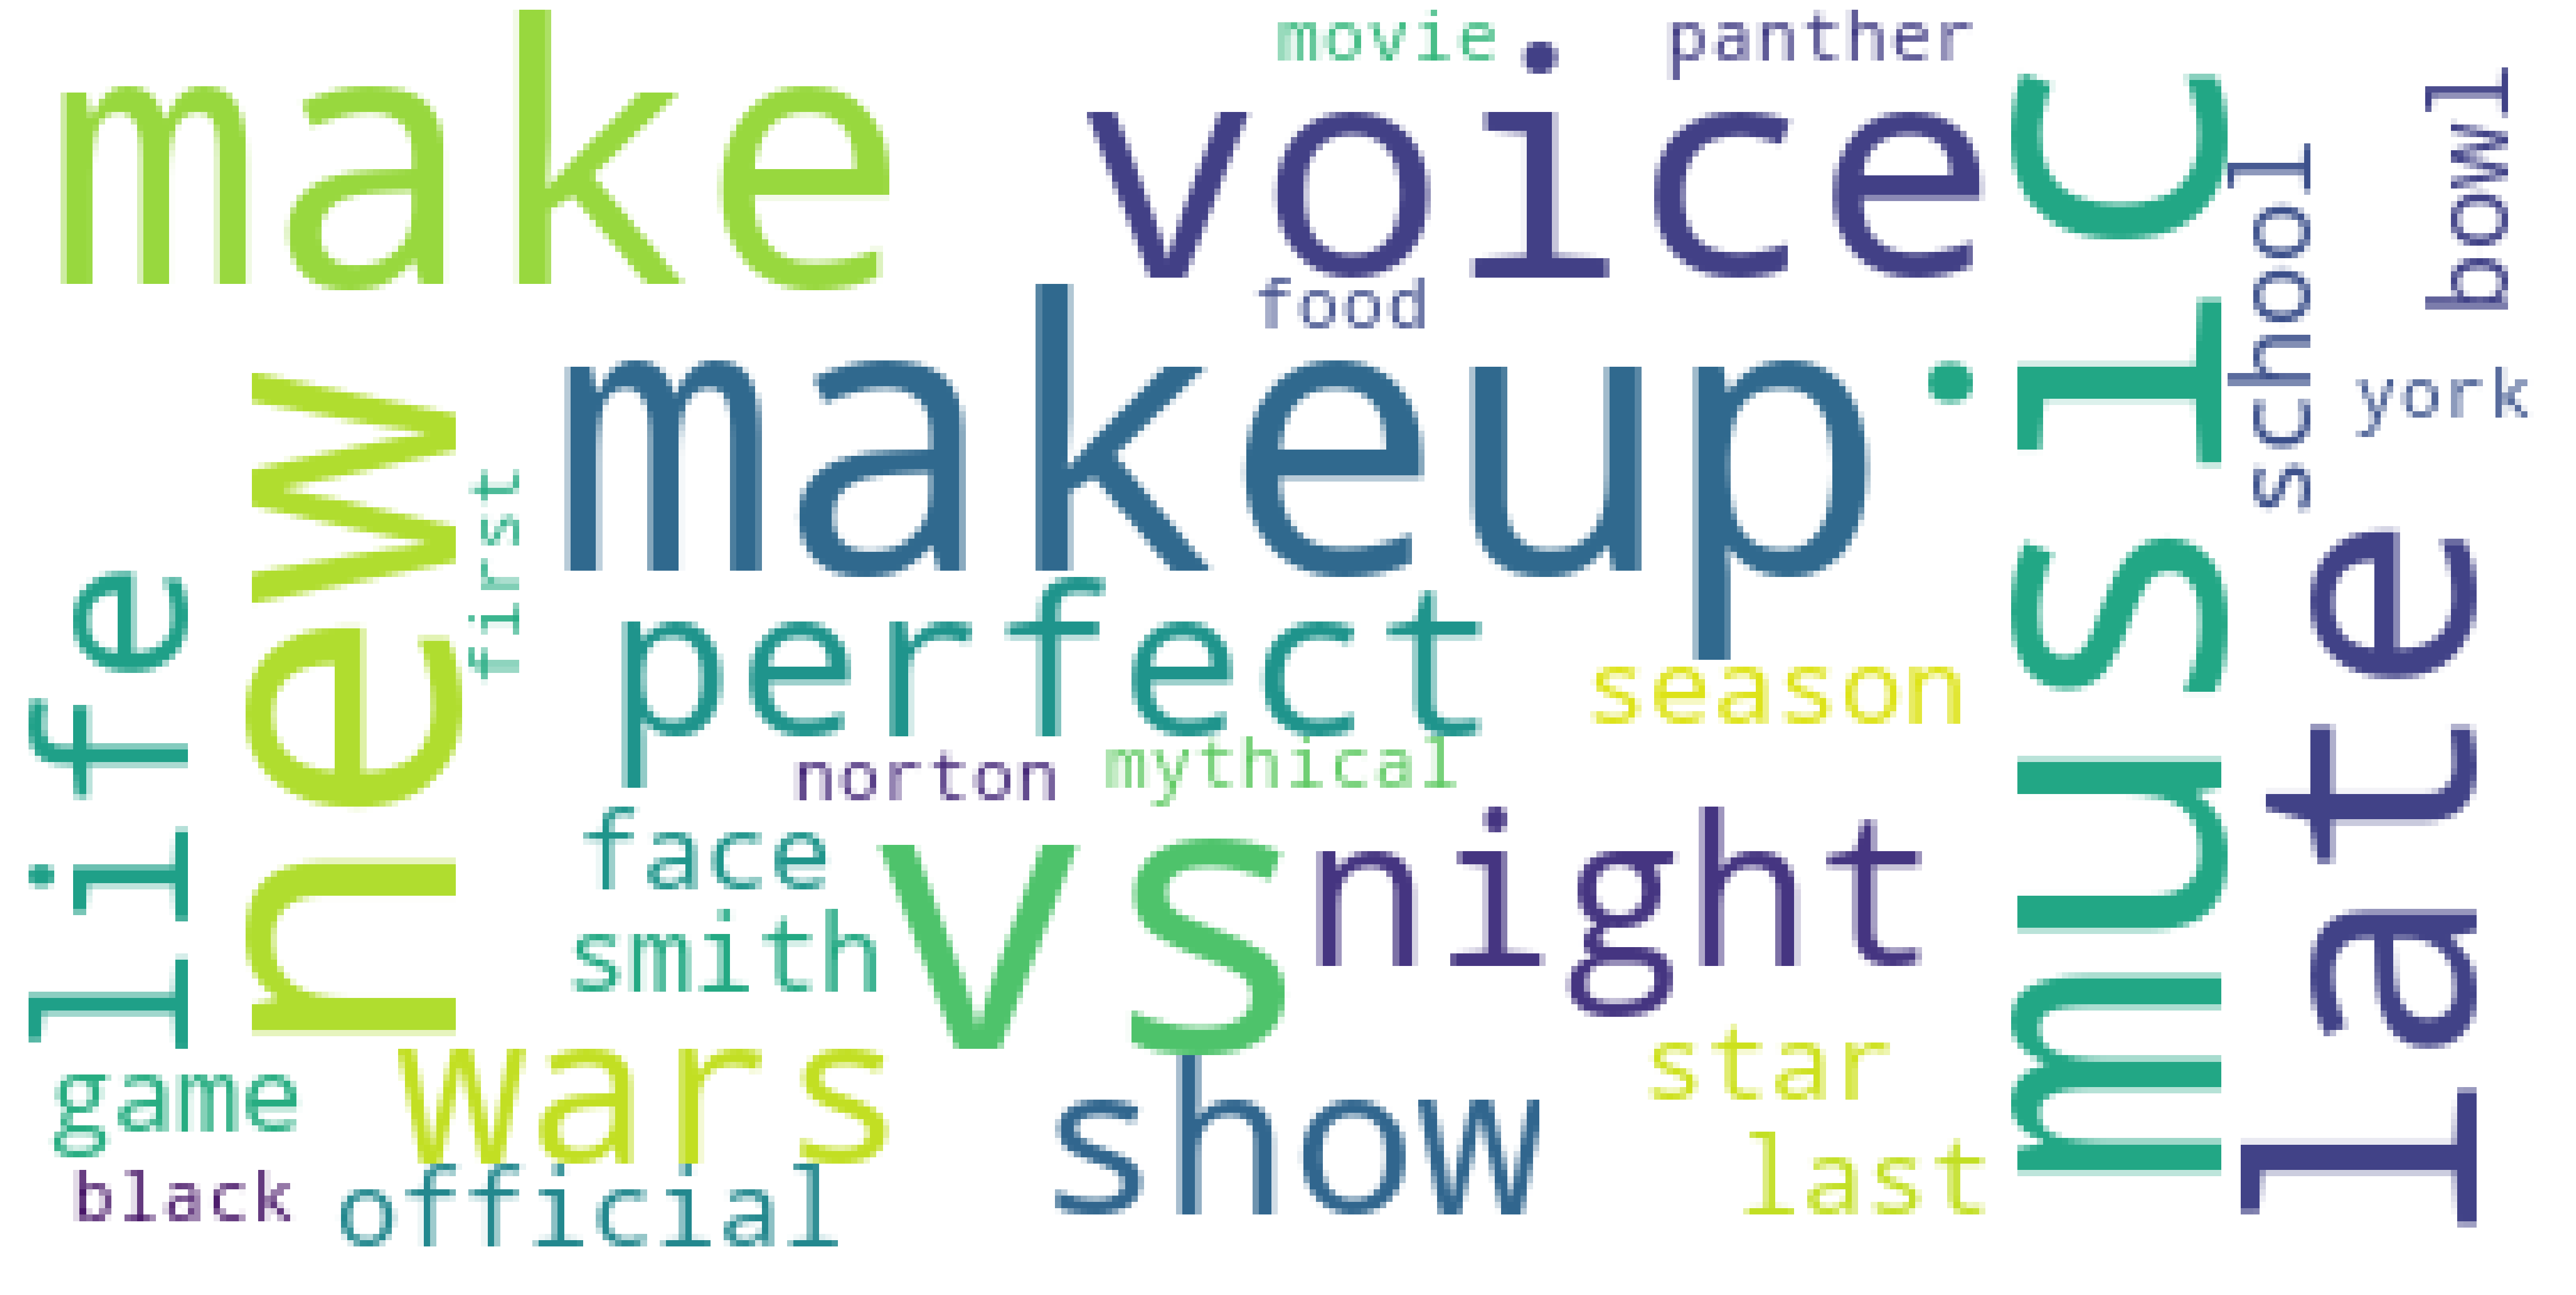

In [286]:
# from collections, a Counter object
cnt = Counter()

# Finding the occurence of words in video titles
for i in df_us['tags_cl']:
    for token in i.split():
        cnt[token] += 1

# Finding the 50 most used words in video titles
dist = cnt.most_common(30)
top_words = []
freqs = []
for word, freq in dist:
    top_words.append(word)
    freqs.append(freq)
    
# Graphing occurrence of words in title
fig= plt.figure(figsize=(20,9))
plt.xticks(rotation=45)
sns.barplot(top_words, freqs, palette="rocket")
sns.set_style("whitegrid")
sns.set(font_scale=1.2)
plt.xlabel('Top Words in Tags', fontsize=20)
plt.ylabel('Number of Videos', fontsize=20)
plt.title('Occurrence of Words in Video Tags in US', fontsize=24)
plt.show()

# Graphing wordcloud for tags
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize
from wordcloud import WordCloud, STOPWORDS

def wc(data,bgcolor,title):
    plt.figure(figsize = (80,80))
    wc = WordCloud(background_color = bgcolor, max_words = 100,  max_font_size = 60)
    wc.generate(' '.join(data))
    plt.imshow(wc)
    plt.axis('off')
wc(top_words,'white','Common Words' )

#### From Figures above, we can see that words such as  "vs", "new", "music", and "makeup" have a higher occurrences than other words. For "vs", I think this might because viewers are more interested in watching videos focusing on comparison or competition. "music" and "makeup" might used to attract music-lovers and people who love doing makeup. 

### 3. Prediction Models
#### Building models that can be used to predict the performance of a video, such as the predictions on likes, dislikes, views, days to trending, tags, video titles, etc. 
#### The models I am going to apply include but no limited to: Linear Regression, Polynomial Regression, Ridge Regression, Decision Trees and Random Forest. 

### 3.1 Using multiple models to predict the number of views, likes, and dislikes as those features can be used as the indicators of the "popular" videos. 

##### 3.1.1 Linear Regression

In [287]:
###Cleaning data for prediction models

#ratio of view/likes
df["Ratio_View_likes"]=round(df["views"]/df["likes"],3)
#ratio of view/dislikes
df["Ratio_View_dislikes"]=round(df["views"]/df["dislikes"],3)
#ratio of view/comment_count 
df["Ratio_views_comment_count"]=round(df["views"]/df["comment_count"],3)
#ratio of likes/dislikes
df["Ratio_likes_dislikes"]=round(df["likes"]/df["dislikes"],3)

df['publish_Day_of_Week'] = df['publish_Day_of_Week'].replace({'Mon':1,
                                                             'Tue':2,
                                                             'Wed':3,
                                                             'Thu':4,
                                                             'Fri':5,
                                                             'Sat':6,
                                                             'Sun':7})
df['trending_Day_of_Week'] = df['trending_Day_of_Week'].replace({'Mon':1,
                                                             'Tue':2,
                                                             'Wed':3,
                                                             'Thu':4,
                                                             'Fri':5,
                                                             'Sat':6,
                                                             'Sun':7})

#removing the infinite values
df=df.replace([np.inf, -np.inf], np.nan)
df = df.dropna(how='any',axis=0)


,video_id,trending_date,title,channel_title,category,publish_Date,category_id,publish_time,tags,views,...,comments_disabled_True,ratings_disabled_False,ratings_disabled_True,video_error_or_removed_False,video_error_or_removed_True,Tags_count,Ratio_View_likes,Ratio_View_dislikes,Ratio_views_comment_count,Ratio_likes_dislikes
0,SbOwzAl9ZfQ,2017-11-14,CapÃ­tulo 12 | MasterChef 2017,MasterChef 2017,Entertainment,2017-11-13,24,2017-11-13 06:06:22,"[masterchef junior 2017, tv azteca, recetas, c...",310130,...,0,1,0,1,0,20,74.158,859.086,168.916,11.584
1,klOV6Xh-DnI,2017-11-14,ALEXA EX-INTEGRANTE DEL GRUPO TIMBIRICHE RENUN...,Micky Contreras Martinez,People & Blogs,2017-11-13,22,2017-11-13 05:11:58,[la voz mexico 7],104972,...,0,1,0,1,0,1,387.351,603.287,284.477,1.557
2,6L2ZF7Qzsbk,2017-11-14,LOUIS CKAGÃ - EL PULSO DE LA REPÃBLICA,El Pulso De La RepÃºblica,News & Politics,2017-11-13,25,2017-11-13 17:00:02,"[chumel torres, el pulso de la republica, noti...",136064,...,0,1,0,1,0,19,13.465,511.519,224.158,37.989
3,hcY52MFWMDM,2017-11-14,Sismo de 6.7 sacude Costa Rica 12 Noviembre 2017,Casanare,News & Politics,2017-11-13,25,2017-11-13 03:47:10,"[temblor, costa rica, sismo en costa rica]",96153,...,0,1,0,1,0,3,254.373,562.298,462.274,2.211
4,_OXDcGPVAa4,2017-11-14,DOG HACKS | MUSAS LESSLIE LOS POLINESIOS,Musas,Howto & Style,2017-11-13,26,2017-11-13 19:17:48,"[musas, lesslie, karen, hacks, perros, dogs, t...",499965,...,0,1,0,1,0,18,8.653,734.163,67.308,84.847
5,Q9kK6NWZR1U,2017-11-14,Asi se sintio Terremoto en iraq al bordo de ir...,MÃSICA & ENTRETENIMIENTO,Music,2017-11-12,10,2017-11-12 20:17:38,[],129645,...,0,1,0,1,0,1,256.215,1935.000,542.448,7.552
6,c9VTD3n_IDs,2017-11-14,La Resolana con el Capi | Programa 12 noviembr...,La Resolana,People & Blogs,2017-11-13,22,2017-11-13 07:00:03,"[la resolana, la resolana con el capi, tv azte...",75197,...,0,1,0,1,0,9,33.025,1089.812,458.518,33.000
8,uijjYNtl_UM,2017-11-14,7 NiÃ±os Famosos Que No Supieron Adaptarse a L...,Los mejores Top 10,Entertainment,2017-11-12,24,2017-11-12 19:54:12,"[los mejores top 10, top 10 niã±os, top 10, to...",371110,...,0,1,0,1,0,23,18.413,406.919,484.478,22.100
9,cOJ68MQm2ac,2017-11-14,TOP: Los 7 libros infantiles mÃ¡s perturbadore...,DrossRotzank,Entertainment,2017-11-12,24,2017-11-12 21:14:44,"[libros infantiles, dross, terror, horror, miedo]",1111314,...,0,1,0,1,0,5,13.296,506.524,122.042,38.096
10,rZZEeeAVgog,2017-11-14,Franco Escamilla.- Tradiciones y Faitelson,Franco Escamilla,Comedy,2017-11-12,23,2017-11-12 19:30:02,"[la, mesa, reã±oã±a, franco, escamilla, comedi...",471516,...,0,1,0,1,0,14,20.255,1746.356,954.486,86.219


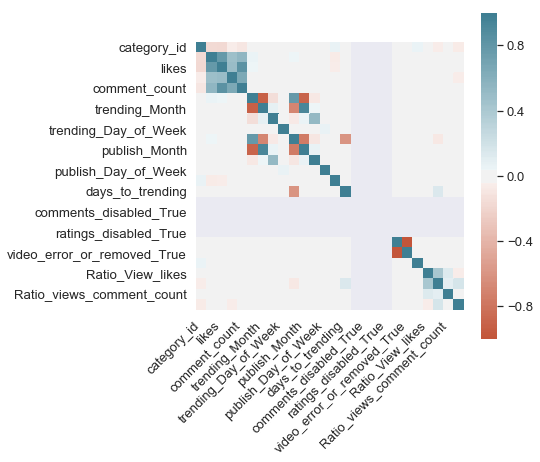

In [331]:
#correlation matrix
data = df

corr = data.corr()
plt.figure(figsize=(6, 6))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [289]:
#Removing non Correlated coloumns
df.drop(['category','video_id','trending_date','publish_Date','publish_Time','publish_time','tags','title','description','channel_title'],axis=1,inplace=True)
df1 = df.pop('country')
df['country'] = df1
df.head()

,category_id,views,likes,dislikes,comment_count,trending_Year,trending_Month,trending_Day,trending_Day_of_Week,publish_Year,...,ratings_disabled_False,ratings_disabled_True,video_error_or_removed_False,video_error_or_removed_True,Tags_count,Ratio_View_likes,Ratio_View_dislikes,Ratio_views_comment_count,Ratio_likes_dislikes,country
0,24,310130,4182,361,1836,2017,11,14,2,2017,...,1,0,1,0,20,74.158,859.086,168.916,11.584,MX
1,22,104972,271,174,369,2017,11,14,2,2017,...,1,0,1,0,1,387.351,603.287,284.477,1.557,MX
2,25,136064,10105,266,607,2017,11,14,2,2017,...,1,0,1,0,19,13.465,511.519,224.158,37.989,MX
3,25,96153,378,171,208,2017,11,14,2,2017,...,1,0,1,0,3,254.373,562.298,462.274,2.211,MX
4,26,499965,57781,681,7428,2017,11,14,2,2017,...,1,0,1,0,18,8.653,734.163,67.308,84.847,MX


In [290]:
#df.info()

#### 3.1.1.1 Linear Regression on prediction on "views"

In [291]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
y_views = df['views']
X_views = df.drop(['views', 'country'],axis=1,inplace=False)
X_views = StandardScaler().fit_transform(X_views) 
train_views,test_views,y_train_views,y_test_views=train_test_split(X_views, y_views, test_size=0.3,shuffle=False)

re_views = LinearRegression()
re_views.fit(train_views, y_train_views)

# predicting the  test set results
y_pred_views = re_views.predict(test_views)
print('MSE: ', np.sqrt(mean_squared_error(y_test_views, y_pred_views)))
print('Variance score: %.2f' % r2_score(y_test_views, y_pred_views))
print("Result :", re_views.score(test_views, y_test_views))
d1 = {'True Labels': y_test_views, 'Predicted Labels': y_pred_views}
SK = pd.DataFrame(data = d1)

MSE:  10646446.766364949
Variance score: 0.52
Result : 0.5235458501137089


/anaconda3/lib/python3.7/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


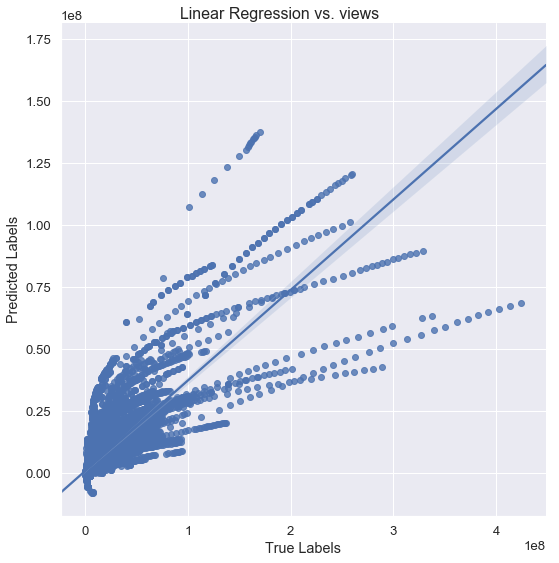

In [292]:
lm1 = sns.lmplot(x="True Labels", y="Predicted Labels", data = SK, size = 8)
fig1 = lm1.fig 
fig1.suptitle("Linear Regression vs. views", fontsize=16)
sns.set(font_scale = 1)

#### 3.1.1.2 Linear Regression on prediction on "likes"

In [293]:
y_likes = df['likes']
X_likes = df.drop(['likes', 'country'],axis=1,inplace=False)
X_likes = StandardScaler().fit_transform(X_likes) 
train_likes,test_likes,y_train_likes,y_test_likes=train_test_split(X_likes, y_likes, test_size=0.3,shuffle=False)

re_likes = LinearRegression()
re_likes.fit(train_likes, y_train_likes)

# predicting the  test set results
y_pred_likes = re_likes.predict(test_likes)
print('MSE: ', np.sqrt(mean_squared_error(y_test_likes, y_pred_likes)))
print('Variance score: %.2f' % r2_score(y_test_likes, y_pred_likes))
print("Result :", re_likes.score(test_likes, y_test_likes))
d1 = {'True Labels': y_test_likes, 'Predicted Labels': y_pred_likes}
SK = pd.DataFrame(data = d1)

MSE:  192124.06031717893
Variance score: 0.62
Result : 0.623880632993678


/anaconda3/lib/python3.7/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


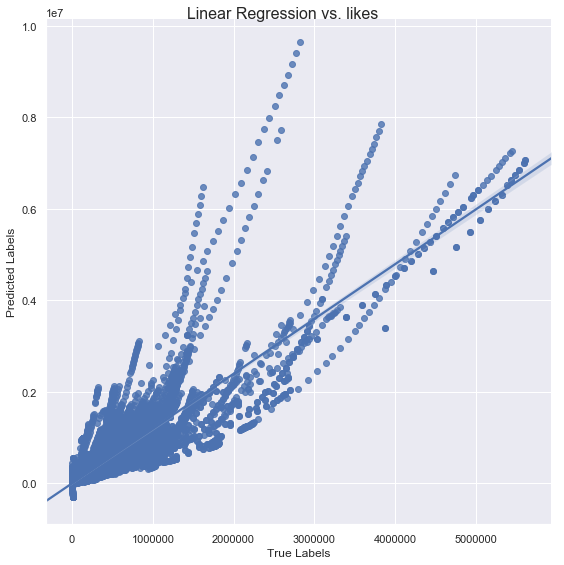

In [294]:
lm1 = sns.lmplot(x="True Labels", y="Predicted Labels", data = SK, size = 8)
fig1 = lm1.fig 
fig1.suptitle("Linear Regression vs. likes", fontsize=16)
sns.set(font_scale = 1)

#### 3.1.1.2 Linear Regression on prediction on "dislikes"

In [295]:
y_dislikes = df['dislikes']
X_dislikes = df.drop(['dislikes', 'country'],axis=1,inplace=False)
X_dislikes = StandardScaler().fit_transform(X_dislikes) 
train_dislikes,test_dislikes,y_train_dislikes,y_test_dislikes=train_test_split(X_dislikes, y_dislikes, test_size=0.3,shuffle=False)

re_dislikes = LinearRegression()
re_dislikes.fit(train_dislikes, y_train_dislikes)

# predicting the  test set results
y_pred_dislikes = re_dislikes.predict(test_dislikes)
print('MSE: ', np.sqrt(mean_squared_error(y_test_dislikes, y_pred_dislikes)))
print('Variance score: %.2f' % r2_score(y_test_dislikes, y_pred_dislikes))
print("Result :", re_dislikes.score(test_dislikes, y_test_dislikes))
d1 = {'True Labels': y_test_dislikes, 'Predicted Labels': y_pred_dislikes}
SK = pd.DataFrame(data = d1)

MSE:  42582.671437266494
Variance score: -0.73
Result : -0.7259657188842792


/anaconda3/lib/python3.7/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


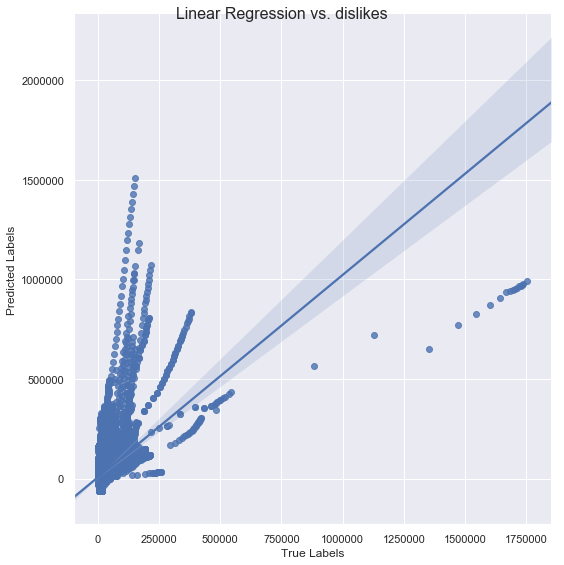

In [296]:
lm1 = sns.lmplot(x="True Labels", y="Predicted Labels", data = SK, size = 8)
fig1 = lm1.fig 
fig1.suptitle("Linear Regression vs. dislikes", fontsize=16)
sns.set(font_scale = 1)

#### 3.1.2 Random Forest Regression

#### 3.1.2.1 Random Forest Regression on prediction on "views"

In [341]:
# find best parameters using GridSearch
nEstimator = [10,150,100]
depth = [5,10,15]

RF = RandomForestRegressor()
hyperParam = [{'n_estimators':nEstimator,'max_depth': depth}]
gsv = GridSearchCV(RF,hyperParam,cv=10,verbose=10,n_jobs=-1)
gsv.fit(train_views, y_train_views)
print("Best HyperParameter: ",gsv.best_params_)
print(gsv.best_score_)
scores = gsv.cv_results_['mean_test_score'].reshape(len(nEstimator),len(depth))


Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done  85 out of  90 | elapsed: 20.4min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 22.0min finished


Best HyperParameter:  {'max_depth': 15, 'n_estimators': 150}
0.9974648514139579


In [297]:

rf_views = RandomForestRegressor(n_estimators = 150 ,max_depth= 15)
rf_views.fit(train_views, y_train_views)

# predicting the  test set results
y_pred_views = rf_views.predict(test_views)
print('MSE: ', np.sqrt(mean_squared_error(y_test_views, y_pred_views)))
print('Variance score: %.2f' % r2_score(y_test_views, y_pred_views))
print("Result :", rf_views.score(test_views, y_test_views))
d1 = {'True Labels': y_test_views, 'Predicted Labels': y_pred_views}
SK = pd.DataFrame(data = d1)

MSE:  8100713.618745384
Variance score: 0.72
Result : 0.7241593305356234


/anaconda3/lib/python3.7/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


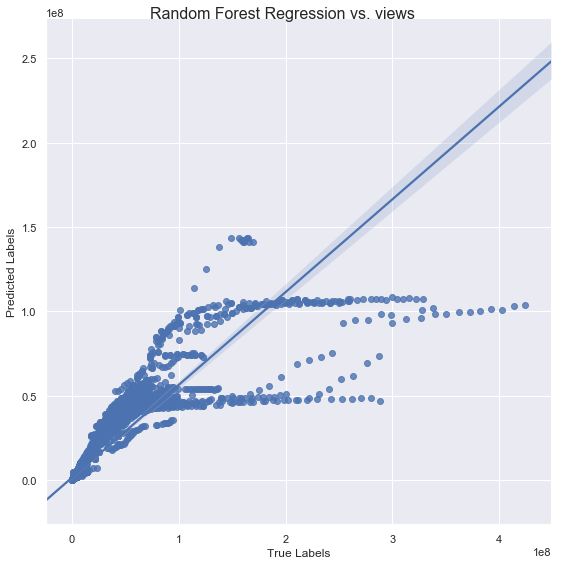

In [298]:
lm1 = sns.lmplot(x="True Labels", y="Predicted Labels", data = SK, size = 8)
fig1 = lm1.fig 
fig1.suptitle("Random Forest Regression vs. views", fontsize=16)
sns.set(font_scale = 1)

#### 3.1.2.2 Random Forest Regression on prediction on "likes"

In [348]:
# find best parameters using GridSearch
nEstimator = [10, 20, 30, 50, 60]
depth = [2, 3, 5,10]

RF = RandomForestRegressor()
hyperParam = [{'n_estimators':nEstimator,'max_depth': depth}]
gsv = GridSearchCV(RF,hyperParam,cv=10,verbose=10,n_jobs=-1)
gsv.fit(train_likes, y_train_likes)
print("Best HyperParameter: ",gsv.best_params_)
print(gsv.best_score_)
scores = gsv.cv_results_['mean_test_score'].reshape(len(nEstimator),len(depth))


Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   38.0s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  8

Best HyperParameter:  {'max_depth': 10, 'n_estimators': 50}
0.9718635738048214


In [45]:
rf_likes = RandomForestRegressor(n_estimators = 50 ,max_depth= 10)
rf_likes.fit(train_likes, y_train_likes)

# predicting the  test set results
y_pred_likes = re_likes.predict(test_likes)
print('MSE: ', np.sqrt(mean_squared_error(y_test_likes, y_pred_likes)))
print('Variance score: %.2f' % r2_score(y_test_likes, y_pred_likes))
print("Result :", re_likes.score(test_likes, y_test_likes))
d1 = {'True Labels': y_test_likes, 'Predicted Labels': y_pred_likes}
SK = pd.DataFrame(data = d1)

MSE:  191746.5868709424
Variance score: 0.63
Result : 0.62535713314169


/anaconda3/lib/python3.7/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


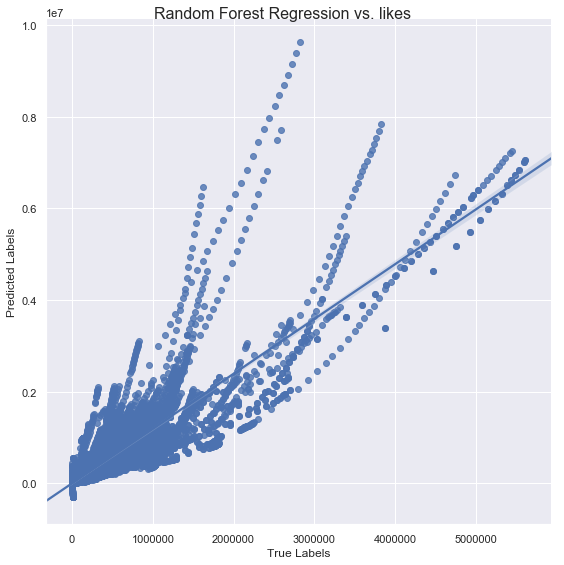

In [46]:
lm1 = sns.lmplot(x="True Labels", y="Predicted Labels", data = SK, size = 8)
fig1 = lm1.fig 
fig1.suptitle("Random Forest Regression vs. likes", fontsize=16)
sns.set(font_scale = 1)

#### 3.1.2.3 Random Forest Regression on prediction on "dislikes"

In [359]:
# find best parameters using GridSearch
nEstimator = [10, 20, 30, 50]
depth = [2,3,5,10]

RF = RandomForestRegressor()
hyperParam = [{'n_estimators':nEstimator,'max_depth': depth}]
gsv = GridSearchCV(RF,hyperParam,cv=10,verbose=10,n_jobs=-1)
gsv.fit(train_dislikes, y_train_dislikes)
print("Best HyperParameter: ",gsv.best_params_)
print(gsv.best_score_)
scores = gsv.cv_results_['mean_test_score'].reshape(len(nEstimator),len(depth))


Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   34.7s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   44.9s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   54.4s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:  7.3min finished


Best HyperParameter:  {'max_depth': 10, 'n_estimators': 30}
0.9710206828245205


In [47]:
re_dislikes = RandomForestRegressor(n_estimators = 30 ,max_depth= 10)
re_dislikes.fit(train_dislikes, y_train_dislikes)

# predicting the  test set results
y_pred_dislikes = re_dislikes.predict(test_dislikes)
print('MSE: ', np.sqrt(mean_squared_error(y_test_dislikes, y_pred_dislikes)))
print('Variance score: %.2f' % r2_score(y_test_dislikes, y_pred_dislikes))
print("Result :", re_dislikes.score(test_dislikes, y_test_dislikes))
d1 = {'True Labels': y_test_dislikes, 'Predicted Labels': y_pred_dislikes}
SK = pd.DataFrame(data = d1)

MSE:  18733.15624281453
Variance score: 0.67
Result : 0.6659678498536283


/anaconda3/lib/python3.7/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


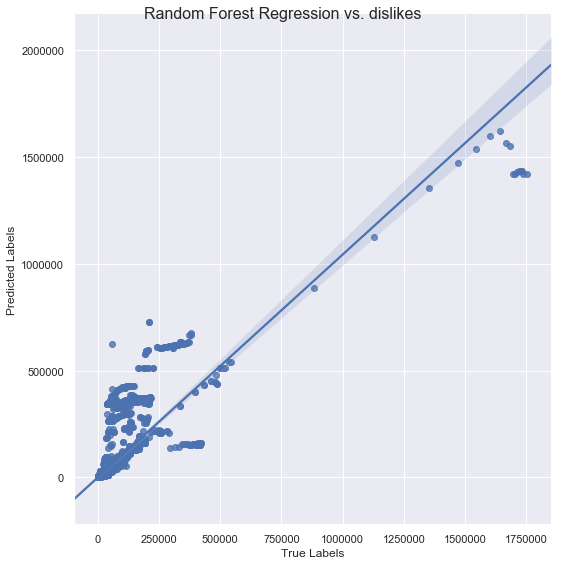

In [48]:
lm1 = sns.lmplot(x="True Labels", y="Predicted Labels", data = SK, size = 8)
fig1 = lm1.fig 
fig1.suptitle("Random Forest Regression vs. dislikes", fontsize=16)
sns.set(font_scale = 1)

#### Conclusion: from the results above,  Linear Regression perform better on predicting views and likes, and Random Forest perform slightly better on dislikes, however, those two model both don't have a very low mse. 

### 3.2 Using multiple models to predict days to trending as it can be used as the indicators of the engagement of videos. 

#### 3.2.1 Linear Regression

In [299]:
X = df.drop(['days_to_trending', 'country'],axis=1)
X = StandardScaler().fit_transform(X) 
y = df['days_to_trending']
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.3,shuffle=False)
re = LinearRegression()
re.fit(X_train, y_train)

# predicting the  test set results
y_pred = re.predict(X_test)
print('MSE', np.sqrt(mean_squared_error(y_test, y_pred)))
print('Variance score: %.2f' % r2_score(y_test, y_pred))
print("Result :",re.score(X_test, y_test))
d1 = {'True Labels': y_test, 'Predicted Labels': y_pred}
SK = pd.DataFrame(data = d1)



MSE 0.6550078389007373
Variance score: 1.00
Result : 0.9999879583221992


/anaconda3/lib/python3.7/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


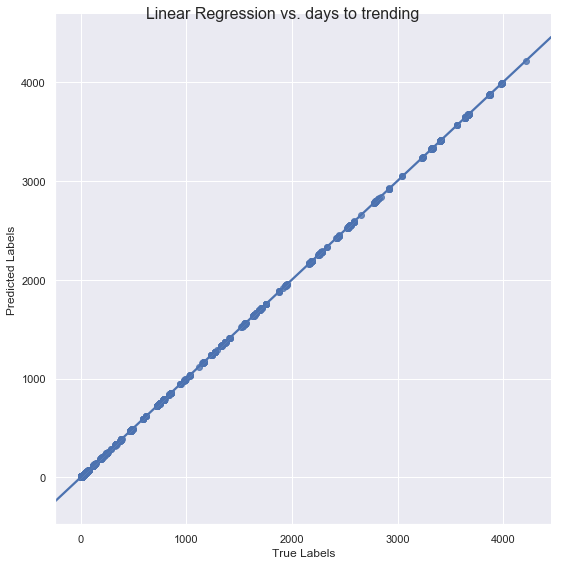

In [300]:
lm1 = sns.lmplot(x="True Labels", y="Predicted Labels", data = SK, size = 8)
fig1 = lm1.fig 
fig1.suptitle("Linear Regression vs. days to trending", fontsize=16)
sns.set(font_scale = 1)

#### 3.2.2 Decision Tree

In [51]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree.export import export_text
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus


/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.tree.export module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.tree. Anything that cannot be imported from sklearn.tree is now part of the private API.
  warnings.warn(message, FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


In [52]:
# Create Decision Tree classifer use best parameter
clf = DecisionTreeRegressor(max_depth=5)
# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)
#Predict the response for test dataset
y_pred = clf.predict(X_test)
print("Accuracy:", clf.score(X_test, y_test))

Accuracy: 0.9922746404811102


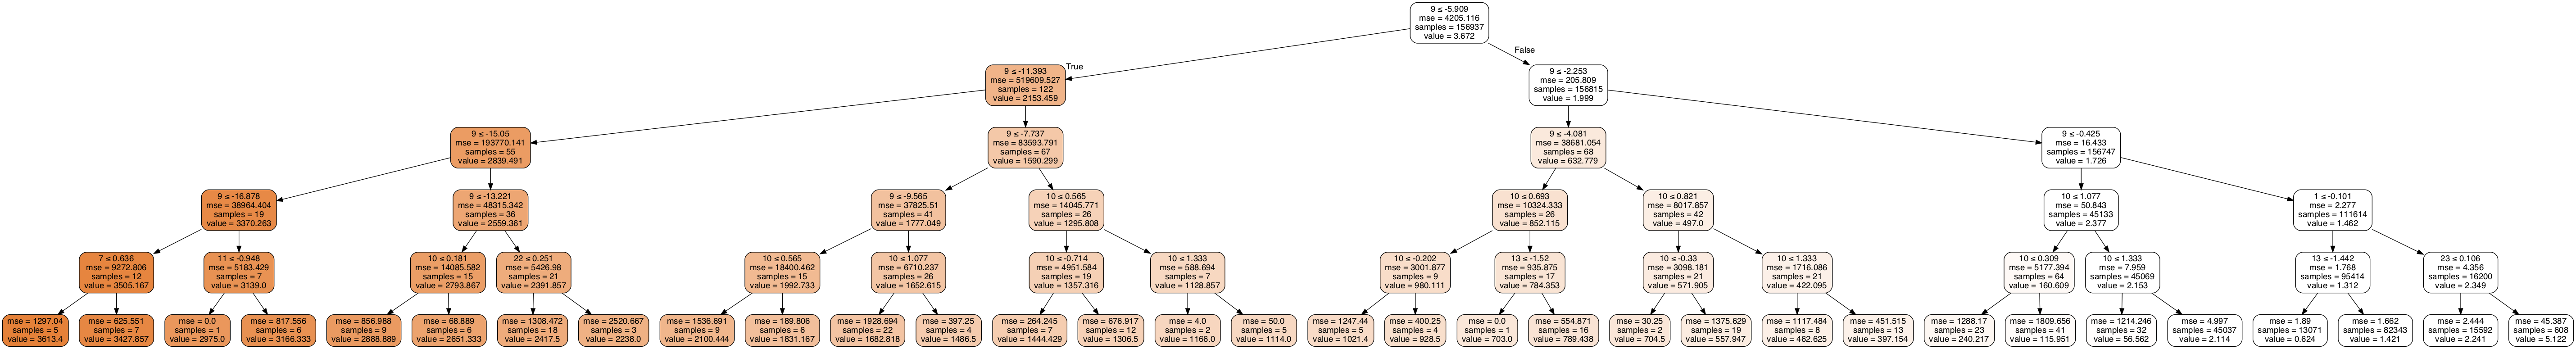

In [63]:
# Plot the tree.
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data, feature_names=pd.DataFrame(X).columns,   
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('trending.png')
Image(graph.create_png())

#### 3.2.3 KNN

In [136]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train,y_train)
#Predict the response for test dataset
y_pred = knn.predict(X_test)
print("Accuracy:", knn.score(X_test, y_test))

Accuracy: 0.20615521855486174


In [137]:
df2 = df[df['days_to_trending'] <= 2]
X = df2.drop(['days_to_trending', 'country'],axis=1)
X = StandardScaler().fit_transform(X) 
y = df2['days_to_trending']
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.3,shuffle=False)

knn2day = KNeighborsClassifier(n_neighbors=4)
knn2day.fit(X_train,y_train)
#Predict the response for test dataset
y_pred = knn2day.predict(X_test)
print("Accuracy:", knn2day.score(X_test, y_test))

Accuracy: 0.8385625984159439


In [142]:
print(df.shape)
print(df2.shape)
print(df4.shape)
print(df6.shape)

(224197, 27)
(141828, 27)
(168055, 27)
(182006, 27)


In [140]:
df4 = df[df['days_to_trending'] <= 4]
X = df4.drop(['days_to_trending', 'country'],axis=1)
X = StandardScaler().fit_transform(X) 
y = df4['days_to_trending']
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.3,shuffle=False)

knn4day = KNeighborsClassifier(n_neighbors=4)
knn4day.fit(X_train,y_train)
#Predict the response for test dataset
y_pred = knn4day.predict(X_test)
print("Accuracy:", knn4day.score(X_test, y_test))


Accuracy: 0.6753476010075966


In [141]:
df6 = df[df['days_to_trending'] <= 6]
X = df6.drop(['days_to_trending', 'country'],axis=1)
X = StandardScaler().fit_transform(X) 
y = df6['days_to_trending']
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.3,shuffle=False)

knn2day = KNeighborsClassifier(n_neighbors=4)
knn2day.fit(X_train,y_train)
#Predict the response for test dataset
y_pred = knn2day.predict(X_test)
print("Accuracy:", knn2day.score(X_test, y_test))

Accuracy: 0.5162631405443024


In [ ]:
acc = [knn2day.score(X_test, y_test), knn4day.score(X_test, y_test), knn6day.score(X_test, y_test)]
print(acc)

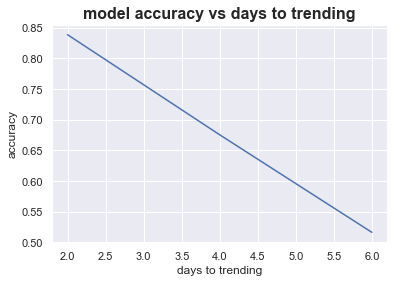

In [146]:
x = [2,4,6]
y = [0.8385625984159439, 0.6753476010075966, 0.5162631405443024] # y = acc 
plt.plot(x, y)
plt.title("model accuracy vs days to trending", fontsize=16, fontweight='bold')
plt.xlabel("days to trending")
plt.ylabel("accuracy")
plt.show()

#### When tried to train the dataset to predict the days to trending, the following results ar what I got:
##### 1. Linear Regression fits will, it can be seen from the graph.
##### 2. Decsion Tree's accuracy is not bad as well, but the depth of the tree is a littleb it high. 
##### 3. KNN is the most interesting part, the accuracy of the model which using the whole dataset is very low, however, when I created and tested knn model by varying the number of trending day from 2 to 6, the accuracy varies. Due to the nature of using a classifier, random guessing would give an accuracy of 50% (0.5). We see that the accuracy drops to a minimum of around 50% when using prediction for at most 6 trending day. This tells us that trying to classifier if a video will trend at most 5-7 trending days is the hardest as the accuracy becomes close to random guessing.

### 3.3 Using multiple models to predict number of tags as using good tags will have positive impact on the video performance. 

#### 3.3.1 Linear Regression

In [321]:
X = df.drop(['Tags_count', 'country'],axis=1)
X = StandardScaler().fit_transform(X) 
y = df['Tags_count']
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.2,shuffle=False)
re = LinearRegression()
re.fit(X_train, y_train)

# predicting the  test set results
y_pred = re.predict(X_test)
print('MSE', np.sqrt(mean_squared_error(y_test, y_pred)))
print('Variance score: %.2f' % r2_score(y_test, y_pred))
print("Result :",re.score(X_test, y_test))

MSE 13.154298284803337
Variance score: -0.19
Result : -0.19292916055353723


#### 3.3.2 Ridge Regression

In [322]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=0.0001, random_state=25, normalize=True)
ridge.fit(X, y)

y_pred = ridge.predict(X_test)
print('MSE', np.sqrt(mean_squared_error(y_test, y_pred)))
print('Variance score: %.2f' % r2_score(y_test, y_pred))
print("Result :",ridge.score(X_test, y_test))


MSE 11.886675481253041
Variance score: 0.03
Result : 0.025907732388355975


#### Since our analysis contains multiple relevant columns, a straightforward linear regression might not be sufficient to detect or show a relationship between the variables. With this, Ridge Regression might possibly serves as better algorithm for linear relationships between multiple variable. Ridge Regression is a technique for analyzing multiple regression data and understanding the multicollinearity between various variables. Multicollinearity is the existence of near-linear relationships among the independent variables.
#### It can be seen from the results, the performance of Ridge Regression is better than simple Linear Regression. 

### Conclusion: 
#### 1. When predicting 'views', 'likes', and 'dislikes', Linear Regression is a useful model.
#### 2. When predicting 'days to trending', all the models perform not bad after I normalizie the dataset. Interesting finding is that when applying KNN,  the accuracy of the model which using the whole dataset is very low, however, when I created and tested knn model by varying the number of trending day from 2 to 6, the accuracy varies. Due to the nature of using a classifier, random guessing would give an accuracy of 50% (0.5). We see that the accuracy drops to a minimum of around 50% when using prediction for at most 6 trending day. This tells us that trying to classifier if a video will trend at most 5-7 trending days is the hardest as the accuracy becomes close to random guessing.
#### 3. When predicting 'Tags count', Ridge Regression give us a better results than simple Linear Regression because of the features we used to analysis are relevant to each other. 